# Simulation on the role of skill and luck in success
This is an attempt to reproduce the results in the famous Veritasium video on the role of skill and luck in success.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from functools import partial

## Generating distributions
We are going to use a two different generators for our simulation:
 -  Uniform distribution
 -  Normal distribution (Mean 50, SD 17) with values clipped below 1 and above 100. ChatGPT suggested SD of 20, but I wanted to choose a value where 3 SD almost lie within the boundaries since we would be clipping at the boundaries.

Currently, the luck and scores are generated via the same distribution and it might be worth trying out independent configurations.

In [2]:
class DistributionGenerator:
    def __init__(self, seed):
        # Adding some determinism to our random generator.
        self._rng = np.random.default_rng(seed=seed)

    def generate(self, n):
        raise NotImplementedError("...")

    def _clip(self, data):
        return np.clip(data, 0, 100)

class NormalDistributionGenerator(DistributionGenerator):
    def __init__(self, seed = 42, mean = 50, std_dev = 17):
        super().__init__(seed)
        self._mean = mean
        self._std_dev = std_dev

    def generate(self, n):
        return self._clip(self._rng.normal(self._mean, self._std_dev, n))

class UniformDistributionGenerator(DistributionGenerator):
    def __init__(self, seed = 42):
        super().__init__(seed)
    
    def generate(self, n):
        return self._clip(self._rng.uniform(0, 100, n))

## Simulator

We will run the analysis with similar parameters to the one in Veritasium -- 1000 rounds of simulation of 18300 applicants battling it out for 11 positions, where skills play 95% role and luck plays the remaining 5%.

We will run both the generators and plot our outputs to try and figure out the role of luck!

In [3]:
# CONSTANTS
NUMBER_ROUNDS=1000
NUMBER_APPLICANTS = 18300
NUMBER_SELECTED = 11
SKILL_WEIGHTAGE = 0.95

In [4]:
class Simulator:
    def __init__(self, generator, skill_weight = SKILL_WEIGHTAGE, applicants = NUMBER_APPLICANTS, selected = NUMBER_SELECTED):
        self._generator = generator
        self._skill_weight = skill_weight
        self._applicants = applicants
        self._selected = selected

    def run_simulation(self, num_rounds = NUMBER_ROUNDS):
        data = np.empty((0, 3), dtype=object)
        for _ in range(num_rounds):
            current_data = self._run_round()
            data = np.vstack((data, current_data))

        return data

    def _run_round(self):
        skill_scores = self._generator.generate(self._applicants)
        luck_scores = self._generator.generate(self._applicants)
        overall_score = skill_scores * self._skill_weight + luck_scores * (1 - self._skill_weight)
    
        selected_applicants_indices = np.argsort(overall_score)[-self._selected:]
        selected_skill_scores = skill_scores[selected_applicants_indices]
        selected_luck_scores = luck_scores[selected_applicants_indices]
    
        avg_skill = np.mean(selected_skill_scores)
        avg_luck = np.mean(selected_luck_scores)
    
        only_skill_based_selection = np.argsort(skill_scores)[-self._selected:]
        common_chosen = np.intersect1d(selected_applicants_indices, only_skill_based_selection).size
    
        return np.array([avg_skill, avg_luck, common_chosen])

In [5]:
def plot_item(data, pos, label):
    plt.boxplot(data, positions=[pos], labels=[label], showmeans=True)
    mean_val = np.mean(data)
    plt.annotate(f'Mean: {mean_val:.2f}', xy=(pos, mean_val), xytext=(pos+0.1, mean_val),
             arrowprops=dict(facecolor='black', arrowstyle='->'))
    

def plot_helper(box_a, box_b):
    label_a = 'Uniform Distribution'
    plot_item(box_a, 1, label_a)
    
    label_b = 'Normal Distribution'
    plot_item(box_b, 2, label_b)

    plt.xlabel('Simulation type')
    plt.ylabel('Value')
    plt.legend([label_a, label_b])

In [6]:
normal_gen = NormalDistributionGenerator()
normal_sim = Simulator(normal_gen)
normal_output = normal_sim.run_simulation()

uniform_gen = UniformDistributionGenerator()
uniform_sim = Simulator(uniform_gen)
uniform_out = uniform_sim.run_simulation()

## Plotting the data

### Average skill level of selected candidates
This is a plot of the average skill level of selected candidates

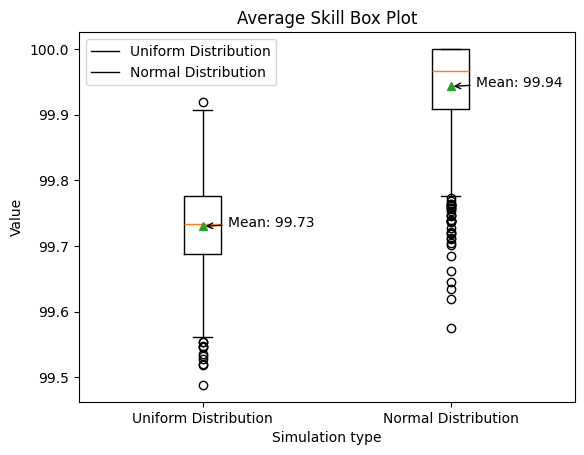

In [7]:
def plot_avg_skill(uniform_dist_skill, normal_dist_skill):
    plot_helper(uniform_dist_skill, normal_dist_skill)
    plt.title('Average Skill Box Plot')
    plt.show()

plot_avg_skill(uniform_out[:,0], normal_output[:,0])

### Average luck for selected candidates
This is a plot of luckiness of selected candidates on average

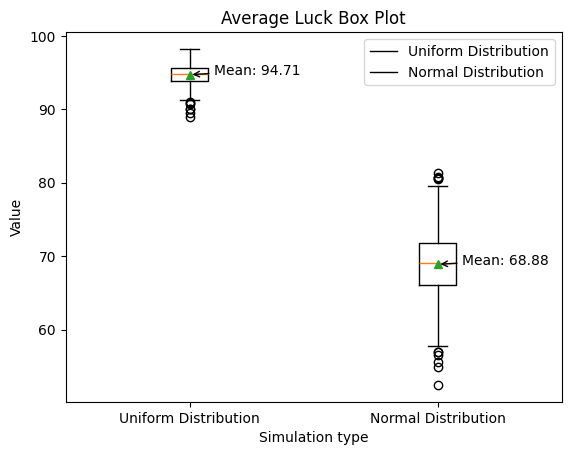

In [8]:
def plot_avg_luck(uniform_dist_luck, normal_dist_luck):
    plot_helper(uniform_dist_luck, normal_dist_luck)
    plt.title('Average Luck Box Plot')
    plt.show()

plot_avg_luck(uniform_out[:,1], normal_output[:,1])

### Average count of people who would have been selected regardless of luck weightage
This is a plot for the count of people who would have been selected in both (95% skill, 5% luck) as well as (100% skill, 0% luck) cases.

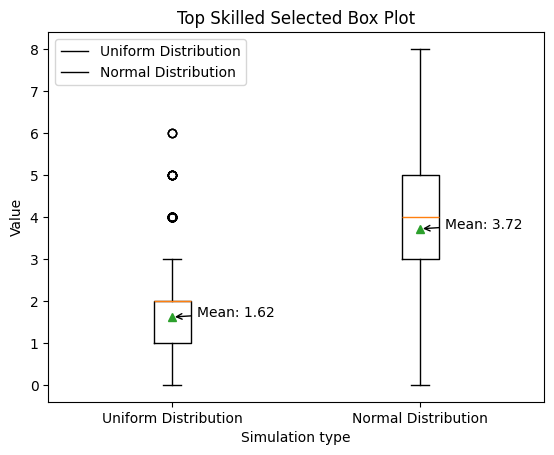

In [9]:
def plot_top_chosen(uniform_dist_chosen, normal_dist_chosen):
    plot_helper(uniform_dist_chosen, normal_dist_chosen)
    plt.title('Top Skilled Selected Box Plot')
    plt.show()

plot_top_chosen(uniform_out[:,2], normal_output[:,2])

## Conclusions

Our uniform distribution simulation achieved results very close to that of the video, but our normal distribution simulation paints a more merit friendly picture. In both the simulations, we see that luck plays a fairly big part even though the people selected were highly skilled.

The simulations can be improved with more realistic data (eg in a lot of cases, mean of distributions tends to be lower than the mid point) as well as generating data that is also less prone to clipping. We can also experiment by changing the parameters in the simulation.